# Summary

In [1]:
from abstractor.train import get_training_batch as get_abstractor_training_batch
from abstractor.utils import AbstractorModel, AbstractorModelRNN
from abstractor.utils import obtain_initial_hidden_states
from bert.utils import obtain_sentence_embeddings
from bert.utils import obtain_word_embeddings
from data.utils import load_training_dictionaries
from extractor.train import get_training_batch as get_extractor_training_batch
from extractor.utils import ExtractorModel
from pytorch_transformers import BertModel
from pytorch_transformers import BertTokenizer
from matplotlib import pyplot as plt
from rl_connection.utils import RLModel
from rl_connection.train import get_training_batch as get_rl_training_batch
from rouge import Rouge

import numpy as np
import pickle
import torch

In [2]:
def print_results(results):
    for x in results:
        print(f'{x}\n')

## Load data

In [3]:
bert_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = BertModel.from_pretrained('bert-base-uncased')

In [4]:
data = load_training_dictionaries()

## Extractor

In [12]:
# Load extractor model:
extractor_model = ExtractorModel(bert_tokenizer, bert_model)
extractor_model_path = "results/models/extractor.pt"
extractor_model.load_state_dict(torch.load(extractor_model_path))

<All keys matched successfully>

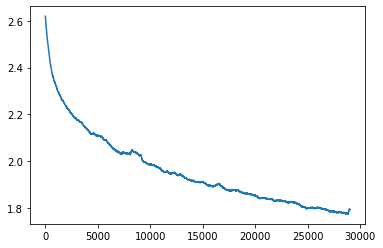

In [34]:
ext_training_loss = pickle.load(open('results/losses/extractor_training_losses.pkl', 'rb'))

def get_moving_average(a, n=3) :
    moving_average = np.cumsum(a, dtype=float)
    moving_average[n:] = moving_average[n:] - moving_average[:-n] # Shift and subtract
    moving_average = moving_average[n - 1:] / n
    return moving_average


moving_average = get_moving_average(ext_training_loss, n=1000)
plt.plot(moving_average)
plt.show()

In [ ]:
# documents, extraction_labels = get_extractor_training_batch(data, batch_size=4)

# sentence_embeddings, sentence_mask = obtain_sentence_embeddings(
#     extractor_model.bert_model, 
#     extractor_model.bert_tokenizer, 
#     documents
# )

# # Predict probability of extraction per sentence
# extraction_probabilities, extraction_mask = extractor_model(sentence_embeddings, sentence_mask, extraction_labels)

In [ ]:
for batch_idx, ext_probs in enumerate(extraction_probabilities):
    ext_sent_indicies = torch.argmax(ext_probs, dim=1)[:extraction_mask[batch_idx].sum()]
    predicted_ext_sents = np.array(documents[batch_idx])[ext_sent_indicies]
    target_ext_sents = np.array(documents[batch_idx])[extraction_labels[batch_idx][:len(documents[batch_idx])].numpy().astype(bool)]
    
    print("############### PREDICTIONS: ###############")
    print_results(predicted_ext_sents)
    print("############### TARGETS: ###############")
    print_results(target_ext_sents)
    print('--------------------------------------------------------')
    print('--------------------------------------------------------')
    print('--------------------------------------------------------\n')
    

## Abstractor

In [ ]:
# Load data:
abstractor_model = AbstractorModelRNN(bert_tokenizer, bert_model)
abstractor_model_path = "results/models/abstractor.pt"
abstractor_model.load_state_dict(torch.load(abstractor_model_path))

In [ ]:
source_documents, target_summaries = get_abstractor_training_batch(data, 1)

# Obtain embeddings
source_document_embeddings, source_mask, source_tokens = obtain_word_embeddings(
    abstractor_model.bert_model, abstractor_model.bert_tokenizer, source_documents, static_embeddings=False
)
target_summary_embeddings, target_mask, target_tokens = obtain_word_embeddings(
    abstractor_model.bert_model, abstractor_model.bert_tokenizer, target_summaries, static_embeddings=True
)

print(source_documents)
print()
print(target_summaries)

In [ ]:
# Obtain extraction probability for each word in vocabulary
extraction_probabilities, teacher_forcing = abstractor_model(
    source_document_embeddings,
    target_summary_embeddings,
    teacher_forcing_pct=0
)  # (batch_size, n_target_words, vocab_size)

vals, predicted_idx = torch.topk((extraction_probabilities), k=1, dim=2)

for x in [abstractor_model.bert_tokenizer.convert_ids_to_tokens(p) for p in predicted_idx.squeeze().tolist()]:
    print(f"{x}")
    print("")
    
print("------------")


# Obtain extraction probability for each word in vocabulary
extraction_probabilities, teacher_forcing = abstractor_model(
    source_document_embeddings,
    target_summary_embeddings,
    teacher_forcing_pct=1
)  # (batch_size, n_target_words, vocab_size)

vals, predicted_idx = torch.topk((extraction_probabilities), k=1, dim=2)

for x in [abstractor_model.bert_tokenizer.convert_ids_to_tokens(p) for p in predicted_idx.squeeze().tolist()]:
    print(f"{x}")
    print("")

## Reinforcement Learning

In [ ]:
rl_model = RLModel(extractor_model, abstractor_model)
rl_model.load_state_dict(torch.load("results/models/rl.pt"))

In [ ]:
source_documents, target_summaries = get_rl_training_batch(data, batch_size=1)

# Obtain embeddings
source_sentence_embeddings, source_mask = obtain_sentence_embeddings(
    rl_model.extractor_model.bert_model,
    rl_model.extractor_model.bert_tokenizer,
    source_documents
)
stop_action_index = source_sentence_embeddings.shape[1]
target_summary_embeddings, target_mask, target_tokens = obtain_word_embeddings(
    rl_model.abstractor_model.bert_model,
    rl_model.abstractor_model.bert_tokenizer,
    target_summaries,
    static_embeddings=True
)

# Run trajectory
actions, log_probs, entropys, values, n_ext_sents = rl_model.sample_actions(
    source_sentence_embeddings,
    source_mask
)

# Obtain abstracted sentence from abstractor
predicted_tokens, word_probabilities = rl_model.create_abstracted_sentences(
    actions,
    source_documents,
    n_ext_sents=n_ext_sents,
    teacher_forcing_pct=0,
    target_summary_embeddings=target_summary_embeddings
)

# Look at extractions
for art_idx, doc_sentences in enumerate(actions):
    for sent_idx in doc_sentences[:-1]:
        print(source_documents[art_idx][sent_idx])
        print()
    print("\n\n-------\n\n")
    
# Look at abstractions
for predicted_abstraction in predicted_tokens:
    solution = list()
    for token in predicted_abstraction:
        solution.append(rl_model.abstractor_model.bert_tokenizer.ids_to_tokens[int(token)])
    print(" ".join(solution))
    print("\n\n")
    
print("-------\n\n")
target_summaries

## Scratch

In [ ]:
from extractor.train import convert_training_dict
from bert.utils import obtain_sentence_embeddings
from data.utils import load_training_dictionaries, create_training_dictionaries

create_training_dictionaries(output_data_path='data/validation_data/', input_file_path='data/validation_data/raw/')

In [ ]:
training_dictionaries = load_training_dictionaries(input_file="data/validation_data/data_dictionaries.pkl")
documents, extraction_labels = convert_training_dict(training_dictionaries)

obtain_sentence_embeddings(
    bert_model, 
    bert_tokenizer, 
    documents, 
    data_dir='data/extractor_data/validation_embeddings/{}', 
    load_old=False
)